In [26]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [29]:
data = torch.load("/home/kim/ice_shelves_flux_decomposition/data/flux_train_tensor.pt", 
                   weights_only = False)

In [30]:
# Define sizes
train_size = int(0.7 * len(data))
test_size = len(data) - train_size
print(f"Train size: {train_size}, Test size: {test_size}")

# Random split
train_dataset, test_dataset = random_split(data, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1024, shuffle = False)

Train size: 2259255, Test size: 968253


In [ ]:
class HelmholtzNN(nn.Module):
    """
    2D Helmholtz decomposition network
    """
    def __init__(self, coordinate_dims = 2, hidden_dim = 256, n_hidden_layers = 6):
        super().__init__()
        assert coordinate_dims == 2
        self.coordinate_dims = coordinate_dims
        self.hidden_dim = hidden_dim

        # Shared trunk (stack of fully connected layers)
        layers = [nn.Linear(coordinate_dims, hidden_dim), nn.SiLU()]
        for _ in range(n_hidden_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.SiLU()]
        self.trunk = nn.Sequential(*layers)

        # Two scalar heads: Psi and Phi
        self.head_df_psi   = nn.Linear(hidden_dim, 1) 
        self.head_cf_phi = nn.Linear(hidden_dim, 1)

    def _grad_scalar(self, s, x):
        # gradient of scalar s(x) w.r.t. x -> shape [batch, 2]
        return torch.autograd.grad(
            outputs = s.sum(),
            inputs = x,
            create_graph = True,
        )[0]

    def forward(self, x, return_parts = False, return_potentials = False):
        """
        x: [N, 2] with requires_grad set (we set it if not)
        returns: v = J∇H + ∇Φ  (shape [N, 2])
        """
        if not x.requires_grad:
            x = x.requires_grad_()

        h = self.trunk(x)
        psi = self.head_df_psi(h) # [N, 1]
        phi = self.head_cf_phi(h) # [N, 1]

        # ∇ psi and ∇ phi
        grad_psi = self._grad_scalar(psi, x) # [N, 2]
        grad_phi = self._grad_scalar(phi, x) # [N, 2]

        # J∇H in 2D: (∂H/∂y, -∂H/∂x)
        J_grad_psi = grad_psi.flip(-1) * torch.tensor([1.0, -1.0], device = x.device, dtype = x.dtype)

        # Combine 
        v = J_grad_psi + grad_phi

        if return_parts or return_potentials:
            out = (v,)
            if return_parts:
                out += (J_grad_psi, grad_phi)
            if return_potentials:
                out += (psi, phi)
            return out

        return v

In [31]:
import torch
import torch.nn as nn

class _ResBlock(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.act  = nn.SiLU()

    def forward(self, h):
        # residual: h -> lin1 -> act -> lin2 -> +h -> act
        out = self.lin2(self.act(self.lin1(h)))
        return self.act(h + out)

class HelmholtzResNN(nn.Module):
    """
    2D Helmholtz decomposition network
    """
    def __init__(self, coordinate_dims = 2, hidden_dim = 256, n_hidden_layers = 6):
        super().__init__()
        assert coordinate_dims == 2
        self.coordinate_dims = coordinate_dims
        self.hidden_dim = hidden_dim

        # Shared trunk (stack of fully connected layers with residual blocks)
        # First projection (as in your code)
        self.inp = nn.Sequential(
            nn.Linear(coordinate_dims, hidden_dim),
            nn.SiLU()
        )
        # Then n_hidden_layers residual blocks
        # e.g. 6 residual blocks
        self.trunk = nn.ModuleList([_ResBlock(hidden_dim) for _ in range(n_hidden_layers)])

        # Two scalar heads: Psi and Phi
        self.head_df_psi = nn.Linear(hidden_dim, 1)
        self.head_cf_phi = nn.Linear(hidden_dim, 1)

    def _grad_scalar(self, s, x):
        # gradient of scalar s(x) w.r.t. x -> shape [batch, 2]
        return torch.autograd.grad(
            outputs = s.sum(),
            inputs  = x,
            create_graph = True,
        )[0]

    def forward(self, x, return_parts = False, return_potentials = False):
        """
        x: [N, 2] with requires_grad set (we set it if not)
        returns: v = J∇ψ + ∇φ  (shape [N, 2])
        """
        if not x.requires_grad:
            # safer: make x a leaf with grad
            x = x.clone().detach().requires_grad_(True)

        h = self.inp(x)
        for blk in self.trunk:
            h = blk(h)

        psi = self.head_df_psi(h)  # [N, 1]
        phi = self.head_cf_phi(h)  # [N, 1]

        # ∇psi and ∇phi
        grad_psi = self._grad_scalar(psi, x)  # [N, 2]
        grad_phi = self._grad_scalar(phi, x)  # [N, 2]

        # J∇ψ in 2D: (∂ψ/∂y, -∂ψ/∂x)
        J_grad_psi = grad_psi.flip(-1) * torch.tensor([1.0, -1.0], device = x.device, dtype = x.dtype)

        # Combine
        v = J_grad_psi + grad_phi

        if return_parts or return_potentials:
            out = (v,)
            if return_parts:
                out += (J_grad_psi, grad_phi)
            if return_potentials:
                out += (psi, phi)
            return out

        return v

In [32]:
# ----- Training loop -----
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HelmholtzResNN().to(device)

opt = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-5)
loss_function = nn.MSELoss()

epochs = 50
# print every N batches
print_every = 500

train_losses = []
test_losses  = []

for ep in range(1, epochs + 1):
    # ------------------ TRAIN ------------------
    model.train()
    train_loss_sum = 0.0
    for i, batch in enumerate(train_loader, start = 1):
        # Split into inputs and targets
        X_batch = batch[:, :2].to(device) # x, y
        Y_batch = batch[:, 2:].to(device) # vxflux, vyflux

        opt.zero_grad(set_to_none = True)
        Y_hat = model(X_batch)
        loss = loss_function(Y_hat, Y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        train_loss_sum += loss.item() * X_batch.size(0)

        if i % print_every == 0:
            print(f"  [ep {ep:03d} | batch {i:05d}] train_batch_loss = {loss.item():.6f}")

    avg_train_loss = train_loss_sum / len(train_loader.dataset)

    # ------------------ EVAL ------------------
    model.eval()
    test_loss_sum = 0.0
    for batch in test_loader:
        X_batch = batch[:, :2].to(device)
        Y_batch = batch[:, 2:].to(device)

        # need requires_grad for autograd in model
        X_batch_grad = X_batch.clone().detach().requires_grad_(True)

        Y_hat = model(X_batch_grad)
        loss = loss_function(Y_hat, Y_batch)
        test_loss_sum += loss.item() * X_batch.size(0)

    avg_test_loss = test_loss_sum / len(test_loader.dataset)

    # store for plotting later
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"[{ep:03d}] train_loss = {avg_train_loss:.6f} | test_loss = {avg_test_loss:.6f}")

  [ep 001 | batch 00500] train_batch_loss = 0.151812
  [ep 001 | batch 01000] train_batch_loss = 0.221223
  [ep 001 | batch 01500] train_batch_loss = 0.184245
  [ep 001 | batch 02000] train_batch_loss = 0.280226
[001] train_loss = 0.278645 | test_loss = 0.195566
  [ep 002 | batch 00500] train_batch_loss = 0.105479
  [ep 002 | batch 01000] train_batch_loss = 0.142718
  [ep 002 | batch 01500] train_batch_loss = 0.225052
  [ep 002 | batch 02000] train_batch_loss = 0.246134
[002] train_loss = 0.169349 | test_loss = 0.171568
  [ep 003 | batch 00500] train_batch_loss = 0.073825
  [ep 003 | batch 01000] train_batch_loss = 0.121862
  [ep 003 | batch 01500] train_batch_loss = 0.280820
  [ep 003 | batch 02000] train_batch_loss = 0.110421
[003] train_loss = 0.158065 | test_loss = 0.149260
  [ep 004 | batch 00500] train_batch_loss = 0.105362
  [ep 004 | batch 01000] train_batch_loss = 0.030779
  [ep 004 | batch 01500] train_batch_loss = 0.136823
  [ep 004 | batch 02000] train_batch_loss = 0.083662

KeyboardInterrupt: 

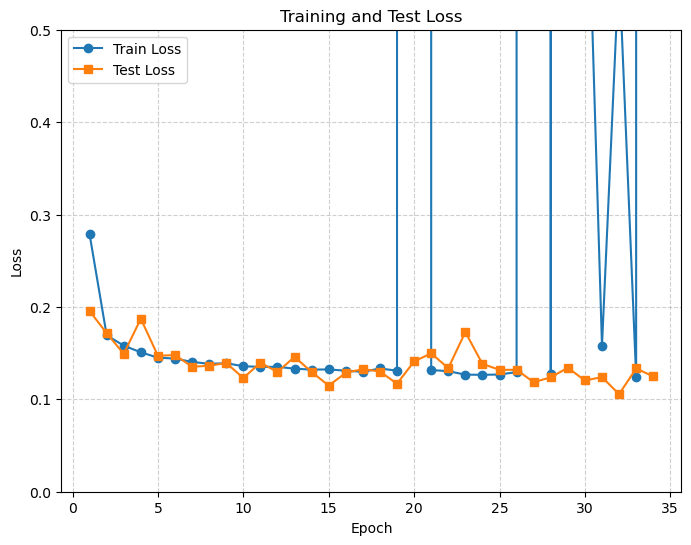

In [34]:
# Assume you already have train_losses and test_losses lists
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs, train_losses, label = "Train Loss", marker = "o")
plt.plot(epochs, test_losses, label = "Test Loss", marker = "s")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.grid(True, linestyle = "--", alpha = 0.6)
plt.ylim(0, 0.5)                # set min/max
plt.show()

# Inference

In [43]:
inference_grid = torch.load("data/bedmap_500m_grid_ross_norm_long.pt")
X_grid = inference_grid.to(device).T
print(X_grid.shape)

torch.Size([1955696, 2])


In [ ]:
xmin, xmax = 0, 0.1
ymin, ymax = 0, 0.1

mask = (
    (X_grid[:, 0] >= xmin) & (X_grid[:, 0] <= xmax) &
    (X_grid[:, 1] >= ymin) & (X_grid[:, 1] <= ymax)
)

X_grid_sub = X_grid[mask]   # shape (N_sub, 2)
print(X_grid_sub.shape)

torch.Size([413, 2])


In [49]:
model.eval()
prediction = model(X_grid_sub)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 23.65 GiB of which 1.69 MiB is free. Including non-PyTorch memory, this process has 23.63 GiB memory in use. Of the allocated memory 23.12 GiB is allocated by PyTorch, and 61.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF